In [4]:
### from https://github.com/deep-learning-with-pytorch/dlwpt-code

In [1]:
import torch
import torch.nn as nn

In [2]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block=self.build_conv_block(dim)
    
    def build_conv_block(self, dim):
        conv_block=[]
        conv_block+=[nn.ReflectionPad2d(1)] # Reflection padding on 4 sides, single input argument for same pad value for each side
        conv_block+=[nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                    nn.InstanceNorm2d(dim), # Normalization over mini batch 2D inputs
                    nn.ReLU(True)]
        conv_block+=[nn.ReflectionPad2d(1)]
        conv_block+=[nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                    nn.InstanceNorm2d(dim)]
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [14]:
# Input: (N, C, Hin, Win)
# Output: (N, C, Hout, Wout)
# Hout = Hin + padding_top + padding_bottom
# Wout = Win + padding_left + padding_right

m = nn.ReflectionPad2d(1)
input = torch.arange(9, dtype=torch.float).reshape(1,1,3,3)
print(f'input:\n {input}')
print(f'm(input):\n {m(input)}')

m2=nn.ReflectionPad2d((2,1,2,1))
print(f'm2(input):\n {m2(input)}')

m3=nn.ReflectionPad2d(2)
print(f'm3(input):\n {m3(input)}')

input:
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
m(input):
 tensor([[[[4., 3., 4., 5., 4.],
          [1., 0., 1., 2., 1.],
          [4., 3., 4., 5., 4.],
          [7., 6., 7., 8., 7.],
          [4., 3., 4., 5., 4.]]]])
m2(input):
 tensor([[[[8., 7., 6., 7., 8., 7.],
          [5., 4., 3., 4., 5., 4.],
          [2., 1., 0., 1., 2., 1.],
          [5., 4., 3., 4., 5., 4.],
          [8., 7., 6., 7., 8., 7.],
          [5., 4., 3., 4., 5., 4.]]]])
m3(input):
 tensor([[[[8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.],
          [5., 4., 3., 4., 5., 4., 3.],
          [8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.]]]])


In [28]:
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9):
        '''
        input_nc = input channels
        output_nc = output channels
        n_blocks = number of resnet block
        ngf = ?
        '''
        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()
        self.input_nc=input_nc
        self.output_nc=output_nc
        self.ngf=ngf

        model = [nn.ReflectionPad2d(3),
                nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                nn.InstanceNorm2d(ngf),
                nn.ReLU(True)]
        
        n_downsampling=2
        for i in range(n_downsampling):
            mult=2**i
            model+=[nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size=3, stride=2, padding=1, bias=True)                     , nn.InstanceNorm2d(ngf*mult*2),
                    nn.ReLU(True)]
        
        mult=2**n_downsampling
        for i in range(n_blocks):
            model+=[ResNetBlock(ngf*mult)]
        for i in range(n_downsampling):
            mult=2**(n_downsampling-i)
            model+=[nn.ConvTranspose2d(ngf*mult, int(ngf*mult/2),
                kernel_size=3, stride=2,
                padding=1, output_padding=1,
                bias=True),
                nn.InstanceNorm2d(int(ngf*mult/2)),
                nn.ReLU(True)]
        model+=[nn.ReflectionPad2d(3)]
        model+=[nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model+=[nn.Tanh()]
        
        self.model=nn.Sequential(*model)
    
    def forward(self, input):
        return self.model(input)

In [29]:
netG = ResNetGenerator()

In [30]:
model_path='horse2zebra_0.4.0.pth'
model_data=torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [31]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [33]:
from PIL import Image
from torchvision import transforms

In [34]:
preprocess=transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

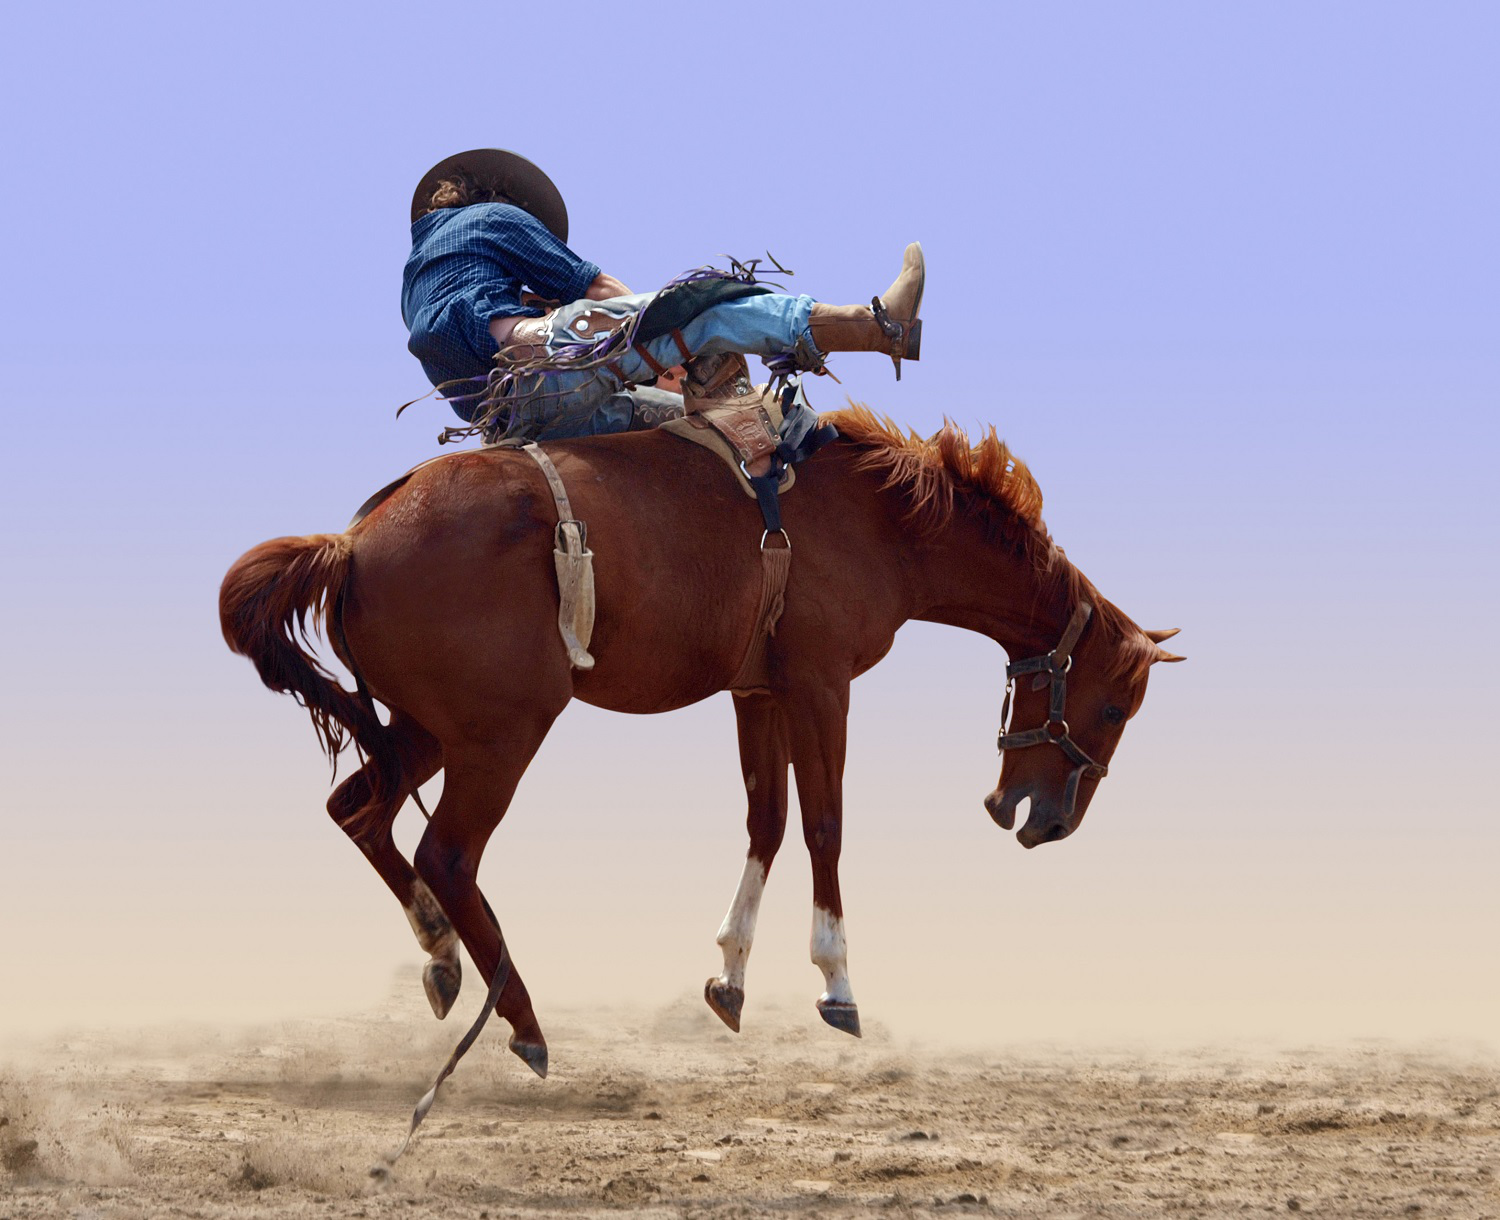

In [35]:
img=Image.open('horse.jpg')
img

In [36]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [37]:
batch_out=netG(batch_t)

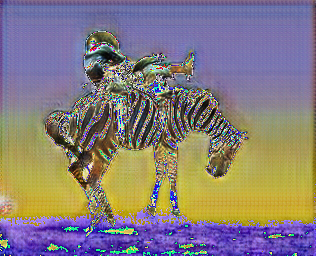

In [45]:
out_t=(batch_out.data.squeeze()) # .squeeze to remove batch dimension
out_img=transforms.ToPILImage()(out_t)
out_img

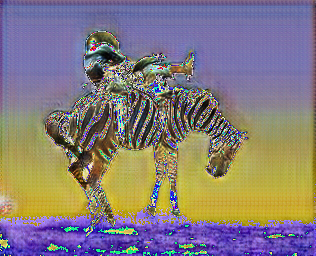

In [46]:
out_t=(batch_out.data.squeeze()+1.0) # .squeeze to remove batch dimension
out_img=transforms.ToPILImage()(out_t)
out_img

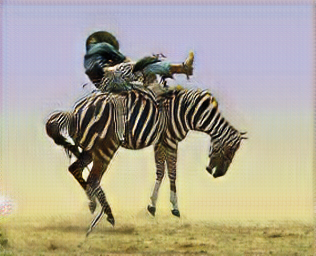

In [47]:
out_t=(batch_out.data.squeeze()+1.0)/2.0 # .squeeze to remove batch dimension
out_img=transforms.ToPILImage()(out_t)
out_img

In [43]:
print(f'batch_out.shape: {batch_out.shape}')
print(f'out_t.shape: {out_t.shape}')

batch_out.shape: torch.Size([1, 3, 256, 316])
out_t.shape: torch.Size([3, 256, 316])


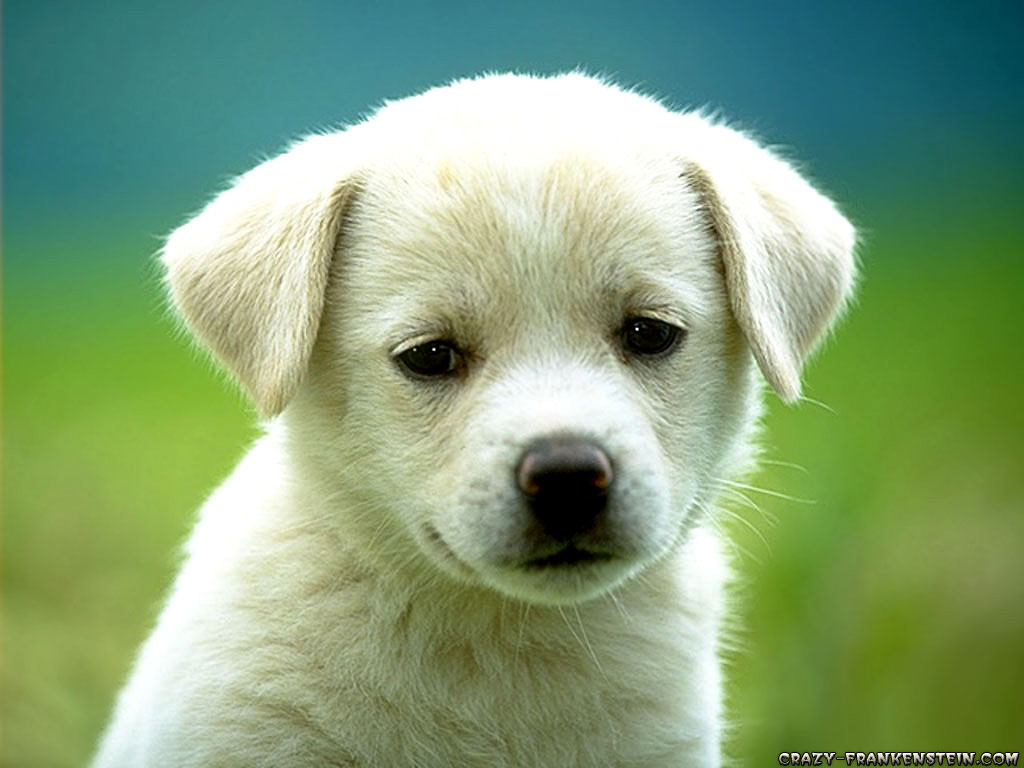

In [48]:
dogimg = Image.open("D:\\OneDrive\\Pictures\\doggy.jpg")
dogimg

In [49]:
dogimg_t = preprocess(dogimg)
dbatch_t = torch.unsqueeze(dogimg_t, 0)

In [50]:
dbatch_out=netG(dbatch_t)

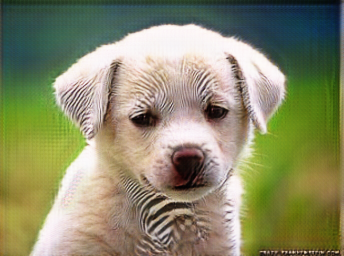

In [51]:
dout_t=(dbatch_out.data.squeeze()+1.0)/2.0 # .squeeze to remove batch dimension
dout_img=transforms.ToPILImage()(dout_t)
dout_img